# Library Import

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image 
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from src.preprocessing.dataLoader_CelebA import CelebALabeledDataset, get_partitioned_dataloaders, create_subset_loader

# Get input parameters

In [2]:
import yaml

# Load config from YAML
with open("config/config.yml", "r") as f:
    config = yaml.safe_load(f)

# Extract sections
PRE = config["PREPROCESSING"]
TRAIN = config["TRAINING"]

# Set constants from preprocessing config
IMAGE_DIR = PRE["image_dir"]
LABEL_FILE = PRE["label_file"]
PARTITION_FILE = PRE["partition_file"]
BATCH_SIZE = PRE["batch_size"]
M_PER_SAMPLE = PRE["m_per_sample"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set constants from training config
LR = TRAIN["lr"]
SCHEDULING = TRAIN["scheduling"]
WEIGHT_DECAY = TRAIN["weight_decay"]
NUM_EPOCHS = TRAIN["num_epochs"]
PATIENCE = TRAIN["patience"]
LOSS_TYPE = TRAIN["loss_type"]
HIDDEN_DIM = TRAIN["hidden_dimension"]
EMBEDDING_DIM = TRAIN["embedding_dimension"]

# CelebA Dataset

In [28]:
# Load datasets
train_loader, val_loader, test_loader = get_partitioned_dataloaders(
    image_dir=IMAGE_DIR,
    label_file=LABEL_FILE,
    m_per_sample=1,
    partition_file=PARTITION_FILE,
    batch_size=1
)

train_loader = create_subset_loader(train_loader, 500)
test_dataloader= create_subset_loader(train_loader, 3000)


# Face Dataset

In [4]:
# !wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
# !rm -rf data
# !unzip "at&t.zip" -d .

In [4]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [5]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        # We need approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0, 1) 
        if should_get_same_class:
            while True:
                # Look until the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                # Look until a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        # Convert to RGB if image is in another format (e.g., RGBA)
        if img0.mode != 'RGB':
            img0 = img0.convert('RGB')
        if img1.mode != 'RGB':
            img1 = img1.convert('RGB')

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        # Return the images, similarity label (0 or 1), and the original class labels
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32)), img0_tuple[1], img1_tuple[1]
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [6]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="data/v2/data/faces/training/")

# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

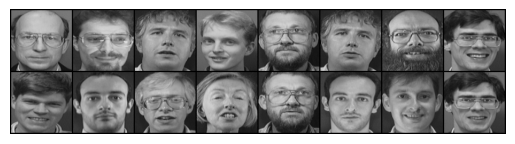

[1. 1. 1. 1. 0. 1. 1. 0.]


In [7]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

# Network

In [8]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            

        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

In [9]:
import torch
import torch.nn as nn
from torchvision.models import resnet18

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Using ResNet18 as the backbone with 3-channel input
        self.cnn1 = resnet18(pretrained=True)  # Using pretrained weights
        
        # Remove the original fully connected layer of ResNet18
        self.cnn1.fc = nn.Identity()
        
        # Setting up your custom Fully Connected Layers
        # ResNet18 outputs 512 features
        self.fc1 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 256),
        )
        
    def forward_once(self, x):
        # Forward pass through ResNet18
        output = self.cnn1(x)
        # Flatten the output
        output = output.view(output.size()[0], -1)
        # Forward pass through custom FC layers
        output = self.fc1(output)
        return output
    
    def forward(self, input1, input2):
        # Forward pass for both inputs
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [10]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [11]:
class ArcFaceLoss(nn.Module):
    def __init__(self, num_classes=40, embedding_size=256, margin=0.9, scale=200.0):
        """
        ArcFace: Additive Angular Margin Loss for Deep Face Recognition
        (https://arxiv.org/pdf/1801.07698.pdf)
        Args:
            num_classes: The number of classes in your training dataset
            embedding_size: The size of the embeddings that you pass into
            margin: m in the paper, the angular margin penalty in radians
            scale: s in the paper, feature scale
        """
        super().__init__()
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.margin = margin
        self.scale = scale
        
        self.W = torch.nn.Parameter(torch.Tensor(num_classes, embedding_size))
        nn.init.xavier_normal_(self.W)
        
    def forward(self, embedding1, embedding2, label1, label2):
        """
        Args:
            embeddings: (None, embedding_size)
            labels: (None,)
        Returns:
            loss: scalar
        """
        # Concatenate embeddings with label information
        embeddings = torch.cat([embedding1, embedding2])
        labels = torch.cat([label1, label2])
        cosine = self.get_cosine(embeddings) # (None, n_classes)
        mask = self.get_target_mask(labels) # (None, n_classes)
        cosine_of_target_classes = cosine[mask == 1] # (None, )
        modified_cosine_of_target_classes = self.modify_cosine_of_target_classes(
            cosine_of_target_classes
        ) # (None, )
        diff = (modified_cosine_of_target_classes - cosine_of_target_classes).unsqueeze(1) # (None,1)
        logits = cosine + (mask * diff) # (None, n_classes)
        logits = self.scale_logits(logits) # (None, n_classes)
        return nn.CrossEntropyLoss()(logits, labels)
        
    def get_cosine(self, embeddings):
        """
        Args:
            embeddings: (None, embedding_size)
        Returns:
            cosine: (None, n_classes)
        """
        cosine = F.linear(F.normalize(embeddings), F.normalize(self.W))
        return cosine
    
    def get_target_mask(self, labels):
        """
        Args:
            labels: (None,)
        Returns:
            mask: (None, n_classes)
        """
        batch_size = labels.size(0)
        onehot = torch.zeros(batch_size, self.num_classes, device=labels.device)
        onehot.scatter_(1, labels.unsqueeze(-1), 1)
        return onehot
        
    def modify_cosine_of_target_classes(self, cosine_of_target_classes):
        """
        Args:
            cosine_of_target_classes: (None,)
        Returns:
            modified_cosine_of_target_classes: (None,)
        """
        eps = 1e-6
        # theta in the paper
        angles = torch.acos(torch.clamp(cosine_of_target_classes, -1 + eps, 1 - eps))
        return torch.cos(angles + self.margin)
    
    def scale_logits(self, logits):
        """
        Args:
            logits: (None, n_classes)
        Returns:
            scaled_logits: (None, n_classes)
        """
        return logits * self.scale

In [54]:
# Load the training dataset
train_loader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=64)

# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="data/v2/data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=0, batch_size=1, shuffle=True)

In [12]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = SiameseNetwork().to(DEVICE)
loss_type = "contrastive"

if loss_type == "contrastive":
    criterion = ContrastiveLoss(margin=20).to(DEVICE)
elif loss_type == "arcface":
    criterion = ArcFaceLoss().to(DEVICE)

optimizer = optim.Adam(net.parameters(), lr=0.0005)


c:\Users\ehait\miniconda3\envs\raml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ehait\miniconda3\envs\raml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch number 0
 Current loss 146.17828369140625

Epoch number 0
 Current loss 84.83139038085938

Epoch number 0
 Current loss 91.14183807373047

Epoch number 0
 Current loss 122.30182647705078

Epoch number 1
 Current loss 101.50943756103516

Epoch number 1
 Current loss 90.73863983154297

Epoch number 1
 Current loss 124.49601745605469

Epoch number 1
 Current loss 94.45622253417969

Epoch number 2
 Current loss 170.93338012695312

Epoch number 2
 Current loss 63.66180419921875

Epoch number 2
 Current loss 78.2291259765625

Epoch number 2
 Current loss 112.57778930664062

Epoch number 3
 Current loss 89.51384735107422

Epoch number 3
 Current loss 71.53738403320312

Epoch number 3
 Current loss 69.80189514160156

Epoch number 3
 Current loss 68.17396545410156

Epoch number 4
 Current loss 51.55280685424805

Epoch number 4
 Current loss 70.67347717285156

Epoch number 4
 Current loss 87.87278747558594

Epoch number 4
 Current loss 54.72825622558594

Epoch number 5
 Current loss 60.007

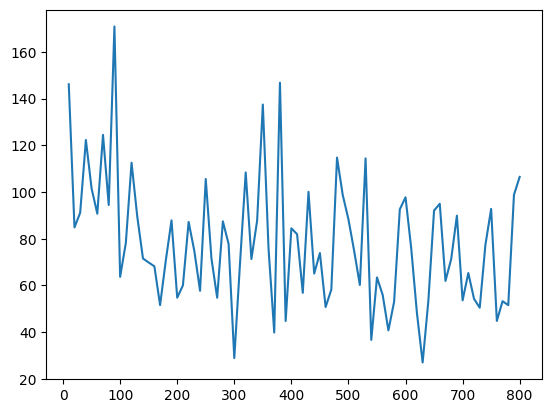

In [13]:
counter = []
loss_history = [] 
iteration_number= 0


# Iterate throught the epochs
for epoch in range(20):

    # Iterate over batches
    for i, (img0, img1, label, label0, label1) in enumerate(train_loader, 0):
        # Send the images and labels to CUDA
        img0, img1, label, label0, label1 = img0.to(DEVICE), img1.to(DEVICE), label.to(DEVICE), label0.to(DEVICE), label1.to(DEVICE)
        

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        if loss_type == "contrastive":
            loss= criterion(output1, output2, label)
        else:
            loss = criterion(output1, output2, label0, label1)

        # Calculate the backpropagation
        loss.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss.item())

show_plot(counter, loss_history)

In [31]:
def evaluate_model(net, test_loader, num_samples=1000):
    """Calculate verification accuracy"""
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i in range(num_samples):
            # Get two random images
            img1, _ , _, label1, _, = next(test_loader)
            _, img2, _ , _, label2 = next(test_loader)
            
            # Get embeddings
            emb1, emb2 = net(img1.to(DEVICE), img2.to(DEVICE))
            
            # Calculate similarity
            euclidean_distance = F.pairwise_distance(emb1, emb2)
            
            # Verify (adjust threshold as needed)
            threshold = 0.2
            prediction = euclidean_distance > threshold
            truth = label1 == label2
            
            correct += (prediction == truth).sum().item()
            total += 1
            
    accuracy = correct / total
    print(f"Verification Accuracy: {accuracy:.4f}")
    return accuracy

# Run evaluation
evaluate_model(net, iter(test_dataloader), 5)

Verification Accuracy: 0.2000


0.2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


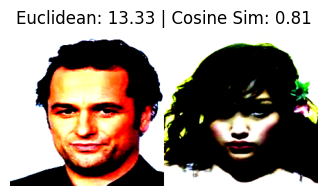

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


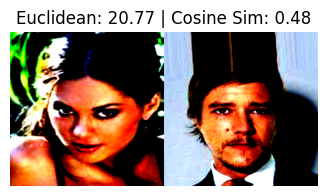

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].


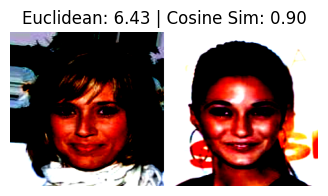

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F

def imshow(img, title=None):
    npimg = img.numpy()
    plt.figure(figsize=(5, 2))
    plt.axis("off")
    if title:
        plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Set your model to eval mode
net.eval()

for i in range(20):
    # Get one sample (batch of 1)
    img1, _, _, label1, _ = next(iter(test_dataloader))
    img2, _, _, label2, _ = next(iter(test_dataloader))

    # Get embeddings
    with torch.no_grad():
        emb1, emb2 = net(img1.to(DEVICE), img2.to(DEVICE))

        # Euklidische Distanz
        euclidean_distance = F.pairwise_distance(emb1, emb2)

        # Cosine Similarity
        cosine_sim = F.cosine_similarity(emb1, emb2)

    # Bilder nebeneinander anzeigen
    concatenated = torch.cat((img1[0], img2[0]), 2)  # dim=2 für Breite

    title = (
        f'Euclidean: {euclidean_distance.item():.2f} | '
        f'Cosine Sim: {cosine_sim.item():.2f}'
    )

    imshow(torchvision.utils.make_grid(concatenated), title)


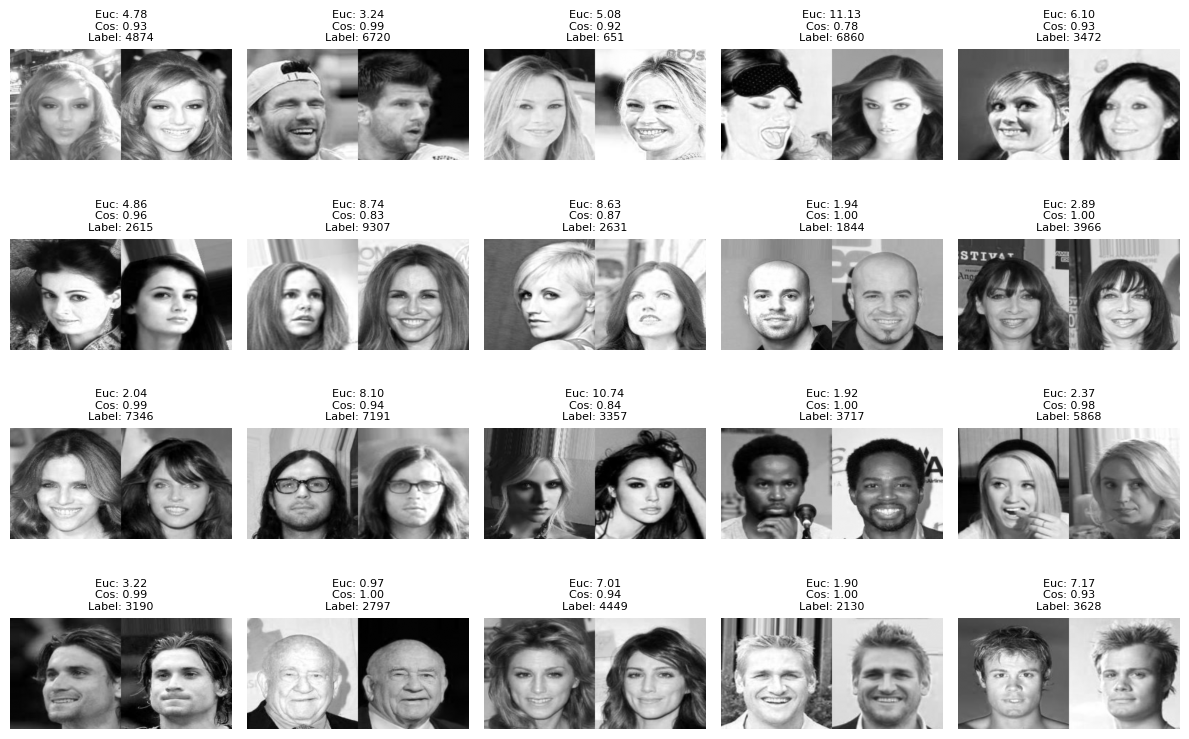

In [30]:
# CHAT TEST
from collections import defaultdict

# 1. Alle Bilder aus test_dataloader einmalig laden und nach Label gruppieren
label_to_images = defaultdict(list)

for img, _, _, label, _ in test_dataloader:
    label_to_images[label.item()].append(img)

# 2. Jetzt 20 Paare mit gleichem Label erzeugen
fig, axs = plt.subplots(4, 5, figsize=(12, 8))
axs = axs.flatten()

net.eval()

i = 0
for label, images in label_to_images.items():
    if len(images) < 2:
        continue  # brauchen mindestens 2 Bilder mit gleichem Label

    # Erzeuge z. B. 2 zufällige Bilder dieses Labels
    img1 = images[0].to(DEVICE)
    img2 = images[1].to(DEVICE)

    with torch.no_grad():
        emb1, emb2 = net(img1, img2)
        euclidean_distance = F.pairwise_distance(emb1, emb2)
        cosine_sim = F.cosine_similarity(emb1, emb2)

    img1_gray = img1[0, 0].cpu()
    img2_gray = img2[0, 0].cpu()
    concatenated = torch.cat((img1_gray, img2_gray), dim=1)

    axs[i].imshow(concatenated.numpy(), cmap="gray")
    axs[i].set_title(
        f"Euc: {euclidean_distance.item():.2f}\nCos: {cosine_sim.item():.2f}\nLabel: {label}",
        fontsize=8
    )
    axs[i].axis("off")

    i += 1
    if i >= 20:
        break

plt.tight_layout()
plt.show()
